# contens

1. Libarary import
2. Data Browser & preprocessing
3. 시계열분석
4. 모델링

## 1. Library improt

In [5]:
import numpy as np
import pandas as pd
import os
from dateutil.parser import parse
import matplotlib as mpl
import matplotlib.pyplot as plt 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split


#os.chdir('C:/elec_used/data/energy')
os.chdir('/home/lyj/elec_used/data/energy')

In [6]:
#os.listdir('C:/elec_used/data/energy')
os.listdir('/home/lyj/elec_used/data/energy')

['train.csv', 'test.csv', 'sample_submission.csv']

In [7]:
train = pd.read_csv('train.csv', encoding = 'euc-kr')
test = pd.read_csv('test.csv', encoding = 'euc-kr')
submission = pd.read_csv('sample_submission.csv', encoding='euc-kr')

In [8]:
train.head(10)

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0
5,1,2020-06-01 05,8010.576,16.9,3.4,93.0,0.0,0.0,0.0,0.0
6,1,2020-06-01 06,7978.176,16.7,3.4,90.0,0.1,0.0,0.0,0.0
7,1,2020-06-01 07,8019.000,16.9,2.3,86.0,0.0,0.1,0.0,0.0
8,1,2020-06-01 08,8020.944,17.8,3.3,80.0,0.0,0.3,0.0,0.0
9,1,2020-06-01 09,8083.152,19.3,2.1,73.0,0.0,0.7,0.0,0.0


In [9]:
test.head(10)

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,2020-08-25 05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1,2020-08-25 06,26.1,1.3,83.0,0.0,0.0,NaN,NaN
7,1,2020-08-25 07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1,2020-08-25 08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1,2020-08-25 09,28.8,1.2,77.0,NaN,1.1,NaN,NaN


In [10]:
submission.head(10)

,num_date_time,answer
0,1 2020-08-25 00,0
1,1 2020-08-25 01,0
2,1 2020-08-25 02,0
3,1 2020-08-25 03,0
4,1 2020-08-25 04,0
5,1 2020-08-25 05,0
6,1 2020-08-25 06,0
7,1 2020-08-25 07,0
8,1 2020-08-25 08,0
9,1 2020-08-25 09,0


## 2. Data Browser & Preprocessing

+ 데이터 설명

```
    < train.csv >
    
        + train 데이터 : 60개 건물들의 2020년 6월 1일 부터 2020년 8월 24일까지의 데이터
        + 1시간 단위로 제공
        + 전력사용량(kWh) 포함
        + train.shape: (122400, 10)
    
    < test.csv >
    
        + test 데이터 : 60개 건물들의 2020년 8월 25일 부터 2020년 8월 31일까지의 데이터
        + 3시간 단위로 제공(강수량의 경우 6시간 단위로 제공, 예보데이터)
        + 전력사용량(kWh) 미포함
        + test.shape: (10080, 9)
        
    
```

 + 비전기냉방설비운영(가스냉방): 0 = 없음, 1 = 있음
 + 태양광보유 : 0 = 없음, 1 = 있음

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   num         122400 non-null  int64  
 1   date_time   122400 non-null  object 
 2   전력사용량(kWh)  122400 non-null  float64
 3   기온(°C)      122400 non-null  float64
 4   풍속(m/s)     122400 non-null  float64
 5   습도(%)       122400 non-null  float64
 6   강수량(mm)     122400 non-null  float64
 7   일조(hr)      122400 non-null  float64
 8   비전기냉방설비운영   122400 non-null  float64
 9   태양광보유       122400 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 9.3+ MB


In [12]:
test.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num           10080 non-null  int64  
 1   date_time     10080 non-null  object 
 2   기온(°C)        3360 non-null   float64
 3   풍속(m/s)       3360 non-null   float64
 4   습도(%)         3360 non-null   float64
 5   강수량(mm, 6시간)  1680 non-null   float64
 6   일조(hr, 3시간)   3360 non-null   float64
 7   비전기냉방설비운영     2296 non-null   float64
 8   태양광보유         1624 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 708.9+ KB


In [13]:
# 건물별 '비전기 냉방설비운영' 과 '태양광보유' 를 판단해 test set의 결측치 보간
train[['num', '비전기냉방설비운영', '태양광보유']]
ice = {}
hot = {}
count = 0
for i in range(0, len(train), len(train)//60):
    count += 1
    ice[count] = train.loc[i, '비전기냉방설비운영']
    hot[count] = train.loc[i, '태양광보유']
    
for i in range(len(test)):
    test.loc[i, '비전기냉방설비운영'] = ice[test['num'][i]]
    test.loc[i, '태양광보유'] = hot[test['num'][i]]

In [14]:
# 시간, 요일, 주말여부 추가
def time(x):
    return int(x[-2:])
train['time'] = train['date_time'].apply(lambda x:time(x))
test['time'] = test['date_time'].apply(lambda x:time(x))

# 평일 = 0~4, 주말= 5~6
def weekday(x):
    return pd.to_datetime(x[:10]).weekday()
train['weekday'] = train['date_time'].apply(lambda x:weekday(x))
test['weekday'] = test['date_time'].apply(lambda x:weekday(x))

# 평일=0, 주말=1
train['weekend'] = train['weekday'].apply(lambda x: 0 if x < 4 else 1)
test['weekend'] = test['weekday'].apply(lambda x: 0 if x < 4 else 1)

In [15]:
# 기온 풍속, 습도 등, 기타 결측치 1/3, 2/3 으로 보간
test = test.interpolate(method='values')
test.head(10)

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유,time,weekday,weekend
0,1,2020-08-25 00,27.800000,1.500000,74.000000,0.0,0.000000,0.0,0.0,0,1,0
1,1,2020-08-25 01,27.633333,1.366667,75.333333,0.0,0.000000,0.0,0.0,1,1,0
2,1,2020-08-25 02,27.466667,1.233333,76.666667,0.0,0.000000,0.0,0.0,2,1,0
3,1,2020-08-25 03,27.300000,1.100000,78.000000,0.0,0.000000,0.0,0.0,3,1,0
4,1,2020-08-25 04,26.900000,1.166667,79.666667,0.0,0.000000,0.0,0.0,4,1,0
5,1,2020-08-25 05,26.500000,1.233333,81.333333,0.0,0.000000,0.0,0.0,5,1,0
6,1,2020-08-25 06,26.100000,1.300000,83.000000,0.0,0.000000,0.0,0.0,6,1,0
7,1,2020-08-25 07,27.000000,1.266667,81.000000,0.0,0.366667,0.0,0.0,7,1,0
8,1,2020-08-25 08,27.900000,1.233333,79.000000,0.0,0.733333,0.0,0.0,8,1,0
9,1,2020-08-25 09,28.800000,1.200000,77.000000,0.0,1.100000,0.0,0.0,9,1,0


In [16]:
train.head(10)

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,time,weekday,weekend
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,0,0,0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,1,0,0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2,0,0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,3,0,0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,4,0,0
5,1,2020-06-01 05,8010.576,16.9,3.4,93.0,0.0,0.0,0.0,0.0,5,0,0
6,1,2020-06-01 06,7978.176,16.7,3.4,90.0,0.1,0.0,0.0,0.0,6,0,0
7,1,2020-06-01 07,8019.000,16.9,2.3,86.0,0.0,0.1,0.0,0.0,7,0,0
8,1,2020-06-01 08,8020.944,17.8,3.3,80.0,0.0,0.3,0.0,0.0,8,0,0
9,1,2020-06-01 09,8083.152,19.3,2.1,73.0,0.0,0.7,0.0,0.0,9,0,0


### train.csv

In [17]:
print('건물번호확인: ')
print(pd.unique(train['num']))
print('---------------------------------------------------------------------------')

print('날짜:')
print(pd.unique(train['date_time']))
print('---------------------------------------------------------------------------')

print('기온확인:')
print(pd.unique(train['기온(°C)']))
print('---------------------------------------------------------------------------')

print('time:')
print(pd.unique(train['time']))
print('---------------------------------------------------------------------------')

건물번호확인: 
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60]
---------------------------------------------------------------------------
날짜:
['2020-06-01 00' '2020-06-01 01' '2020-06-01 02' ... '2020-08-24 21'
 '2020-08-24 22' '2020-08-24 23']
---------------------------------------------------------------------------
기온확인:
[17.6 17.7 17.5 17.1 17.  16.9 16.7 17.8 19.3 20.5 22.1 23.1 23.6 23.8
 24.4 22.7 21.3 19.8 18.6 17.9 17.2 16.6 16.2 15.9 15.7 15.5 14.8 15.
 16.  17.3 16.3 20.4 20.9 21.7 21.2 20.6 20.3 19.9 19.6 19.  18.4 18.3
 18.2 18.1 19.7 20.8 22.  26.1 26.8 27.9 28.2 28.1 21.  20.1 20.  22.4
 23.9 25.  26.  26.4 25.4 24.3 23.2 22.8 21.4 19.5 18.9 18.7 22.3 25.1
 26.3 27.2 27.8 28.5 28.6 25.8 21.1 20.7 19.4 19.2 24.  25.6 29.3 29.4
 30.5 30.6 29.1 27.1 25.2 24.8 23.4 27.4 28.4 28.9 28.  25.7 24.5 23.
 21.6 22.5 25.5 29.8 31.2 31.6 30.7 22.9 27.7 2

### test.csv

In [18]:
print('건물번호확인: ')
print(pd.unique(test['num']))
print('---------------------------------------------------------------------------')

print('날짜:')
print(pd.unique(test['date_time']))
print('---------------------------------------------------------------------------')

print('기온확인:')
print(pd.unique(test['기온(°C)']))
print('---------------------------------------------------------------------------')

print('time:')
print(pd.unique(test['time']))
print('---------------------------------------------------------------------------')

건물번호확인: 
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60]
---------------------------------------------------------------------------
날짜:
['2020-08-25 00' '2020-08-25 01' '2020-08-25 02' '2020-08-25 03'
 '2020-08-25 04' '2020-08-25 05' '2020-08-25 06' '2020-08-25 07'
 '2020-08-25 08' '2020-08-25 09' '2020-08-25 10' '2020-08-25 11'
 '2020-08-25 12' '2020-08-25 13' '2020-08-25 14' '2020-08-25 15'
 '2020-08-25 16' '2020-08-25 17' '2020-08-25 18' '2020-08-25 19'
 '2020-08-25 20' '2020-08-25 21' '2020-08-25 22' '2020-08-25 23'
 '2020-08-26 00' '2020-08-26 01' '2020-08-26 02' '2020-08-26 03'
 '2020-08-26 04' '2020-08-26 05' '2020-08-26 06' '2020-08-26 07'
 '2020-08-26 08' '2020-08-26 09' '2020-08-26 10' '2020-08-26 11'
 '2020-08-26 12' '2020-08-26 13' '2020-08-26 14' '2020-08-26 15'
 '2020-08-26 16' '2020-08-26 17' '2020-08-26 18' '2020-08-26 19'
 '2020-08-26

## 3. 시계열 분석

In [19]:
plt.rcParams.update({'figure.figsize':(10,7), 'figure.dpi':120})
train_date = pd.read_csv('train.csv', parse_dates=['date_time'], encoding='euc-kr')
# train_date.head(10)

## 인덱스로 저장
train_ser = pd.read_csv('train.csv', parse_dates=['date_time'], 
                        encoding='euc-kr', index_col=['date_time'])
#train_ser.head(10)

In [20]:
train_ser.head(10)

,num,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
date_time,,,,,,,,,
2020-06-01 00:00:00,1,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
2020-06-01 01:00:00,1,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2020-06-01 02:00:00,1,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
2020-06-01 03:00:00,1,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
2020-06-01 04:00:00,1,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0
2020-06-01 05:00:00,1,8010.576,16.9,3.4,93.0,0.0,0.0,0.0,0.0
2020-06-01 06:00:00,1,7978.176,16.7,3.4,90.0,0.1,0.0,0.0,0.0
2020-06-01 07:00:00,1,8019.000,16.9,2.3,86.0,0.0,0.1,0.0,0.0
2020-06-01 08:00:00,1,8020.944,17.8,3.3,80.0,0.0,0.3,0.0,0.0


In [41]:
def plot_df(df, x, y, title="", xlabel='Date', ylabels='Value', dpi=100):
    plt.figure(figsize=(16, 5), dpi=dpi)
    plt.rcParams["font.family"] = 'NanumGothic.tff'
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, y=ylabels)
    plt.show()

In [42]:
train_ser.rename(columns={'전력사용량(kWh)':'value'}, inplace=True)

AttributeError: 'AxesSubplot' object has no property 'y'

findfont: Font family ['NanumGothic.tff'] not found. Falling back to DejaVu Sans.
/home/lyj/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lyj/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lyj/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lyj/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lyj/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 47141 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lyj/anaconda

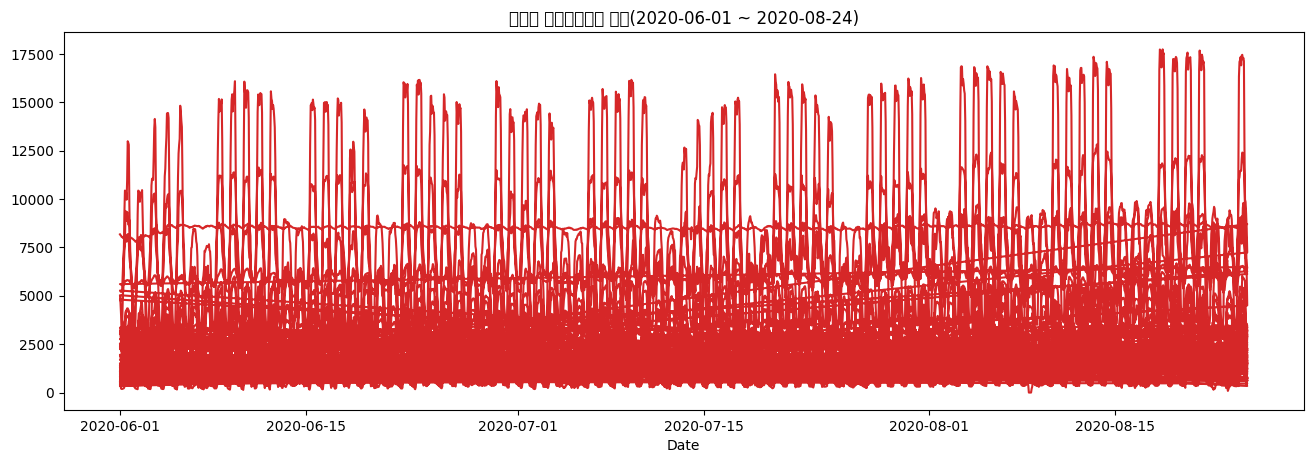

In [43]:
plot_df(train_ser, x=train_ser.index, y=train_ser.value, title="날짜별 전력사용량의 변화(2020-06-01 ~ 2020-08-24)")